In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2 as cv
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import seaborn as sns
import pandas as pd
import os
import statistics
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import random

In [34]:
class ObjectPhasor:
    def __init__(self, G, S, img):
        # G and S are both arrays
        self.img = img
        self.G = G
        self.S = S

    def get_g(self):
        return self.G
    
    def get_s(self):
        return self.S
    
    def get_img(self):
        return self.img

In [35]:
def phasors(img, axis):
    fft=np.fft.fft(img, axis=axis)
    
    G=fft[:,:,1].real/fft[:,:,0].real
    G=np.nan_to_num(G, nan=0.0)

    S=fft[:,:,1].imag/fft[:,:,0].real
    S=np.nan_to_num(S, nan=0.0)

    Ph=np.arctan2(S[:,:], G[:,:])+np.pi
    Ph=np.nan_to_num(Ph, nan=0.0)

    Mod=np.sqrt(G**2+S**2)
    Mod=np.nan_to_num(Mod, nan=0.0)
    
    I=fft[0].real
    return G, S, Ph, Mod, I

In [36]:
def background_subtraction(src):
    # Background Subtraction
    # Little too strong for image at low exposure
    dest = cv.ximgproc.anisotropicDiffusion(src, alpha=0.1, K=10, niters=300)
    src = cv.subtract(src, dest)

    shifted = cv.pyrMeanShiftFiltering(src, 21, 51)
    return shifted 

In [37]:
def watershed_object(image):
    # perform watershed on image and return individual objects in a list

    list_masks = []

    gray=np.sum(image, axis=2)
    Mgray=gray*(gray>40)

    distance = ndi.distance_transform_edt(Mgray)
    coords = peak_local_max(distance, min_distance=8)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=Mgray)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

    for label in np.unique(labels):
        if label == 0:
            continue
        mask = np.zeros(Mgray.shape, dtype='uint8')
        mask[labels == label] = 255

        masked = cv.bitwise_and(image, image, mask=mask)

        list_masks.append(masked)
    
    return list_masks

In [38]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [39]:
def kmeans_points():
    directory = 'Microbeads'

    # init list of object phasors
    phasor_list = []

    # Iterate files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            image=cv.imread(filename=f)
            image=cv.cvtColor(image, cv.COLOR_BGR2RGB) 
            image = cv.medianBlur(image, 5)

            objects = watershed_object(image)

            for obj in objects:
                # G and S are 2D Arrays of shape (image dim, 3)
                G, S, Ph, Mod, I = phasors(obj, axis=2)
                temp = ObjectPhasor(G, S, obj)
                phasor_list.append(temp)
    
    data = []
    for i in range(len(phasor_list)):
        temp = [phasor_list[i].get_g(), phasor_list[i].get_s(), i, phasor_list[i].get_img()]
        data.append(temp)
        
    export_df = pd.DataFrame(data, columns = ['G', 'S', 'ObjNum', 'ObjRef']) 

    # Flatten all the X, Y, Z and make them into array shape (dim, 3)
    X = []
    Y = []
    Z = []

    for i in range(len(phasor_list)):
        x = phasor_list[i].get_g().flatten()
        y = phasor_list[i].get_s().flatten()
        shape = x.shape
        z = np.full(shape=shape, fill_value=i)

        X.extend(x)
        Y.extend(y)
        Z.extend(z)


    df = pd.DataFrame({"X" : X,
                       "Y" : Y,
                       "Z" : Z})
    
    df = df[(df['X'] != 0) & (df['Y'] != 0)] 

    dataset = df.to_numpy()
    xy_sample = df[["X", "Y"]]

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(xy_sample)
    labels = kmeans.predict(xy_sample)

    silhouette_avg = silhouette_score(xy_sample, labels)
    print("Silhouette Score:", silhouette_avg)

    df['Labels'] = labels
    df = (df.groupby('Z')['Labels'].value_counts()
         .rename('counts').reset_index()
         .drop_duplicates('Z'))

    export_df = export_df.join(df, how='inner',lsuffix='ObjNum', rsuffix='Z')
    export_df = export_df[['G', 'S', 'ObjNum', 'Labels']]
    
    # Plot the data points and their cluster assignments

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=labels, cmap='viridis')

    # # Set light blue background 
    # ax.xaxis.set_pane_color((0.8, 0.8, 1.0, 1.0)) 
    # ax.yaxis.set_pane_color((0.8, 0.8, 1.0, 1.0)) 
    # ax.zaxis.set_pane_color((0.8, 0.8, 1.0, 1.0))
    # ax.set_title("K-means Clustering on Phasors")
    # ax.set_xlabel("G Value")
    # ax.set_ylabel("S Value")
    # ax.set_zlabel("Object Number")
    # fig.show()

    return export_df

In [77]:
def user_grouping():
    directory = 'Microbeads'

    # init list of object phasors
    phasor_list = []

    # Iterate files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            image=cv.imread(filename=f)
            image=cv.cvtColor(image, cv.COLOR_BGR2RGB) 
            image = cv.medianBlur(image, 5)

            objects = watershed_object(image)

            for obj in objects:
                # G and S are 2D Arrays of shape (image dim, 3)
                G, S, Ph, Mod, I = phasors(obj, axis=2)
                temp = ObjectPhasor(G, S, obj)
                phasor_list.append(temp)

    data = []
    
    for i in range(len(phasor_list)):
        temp = [phasor_list[i].get_g(), phasor_list[i].get_s(), i, phasor_list[i].get_img()]
        data.append(temp)
    export_df = pd.DataFrame(data, columns = ['G', 'S', 'ObjNum', 'ObjRef']) 

    # this value needs work
    export_df['Labels'] = export_df.apply(lambda x: 1 if statistics.median([i for i in x['S'].flatten() if i != 0]) <= -0.20 else 0, axis=1)
        
    return export_df

In [41]:
def kmeans_colors(img, n):
    image = img
    number_of_colors = n

    modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    plt.title('Colors Detection', fontsize=20)
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.show()
    return hex_colors, rgb_colors

In [42]:
def color_computing(rgb_colors):
    DIFF = []
    # init list of object phasors
    phasor_list = []

    directory = 'Microbeads'

    # Iterate files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            image=cv.imread(filename=f)
            image=cv.cvtColor(image, cv.COLOR_BGR2RGB) 
            image = cv.medianBlur(image, 5)

            objects = watershed_object(image)

            for obj in objects:
                # G and S are 2D Arrays of shape (image dim, 3)
                G, S, Ph, Mod, I = phasors(obj, axis=2)
                temp = ObjectPhasor(G, S, obj)
                phasor_list.append(temp)
    
    for phasor_object in phasor_list:
        DIFF_COLOR = []
        for color in range(len(rgb_colors)):
            # there is took much black space in the image that this apprach is broken
            diff = np.abs(phasor_object.img - rgb_colors[color])
            DIFF_COLOR.append(diff.mean())
        DIFF.append(DIFF_COLOR)

    return np.array(DIFF)

In [73]:
def test_accuracy(kmeans_df, user_df):
    kmeans_dict = kmeans_df['Labels'].to_dict()
    user_dict = user_df['Labels'].to_dict()
    accuracy = []
    
    user_labels = []
    for key in kmeans_dict:
        user_labels.append(user_dict[key])
        if kmeans_dict[key] == user_dict[key]:
            accuracy.append(1)
        else:
            accuracy.append(0)
    
    score = sum(accuracy) / len(kmeans_dict) * 100
    print(score)
    # Create the confusion matrix
    cm = confusion_matrix(np.array(user_labels), np.array(kmeans_df['Labels']))

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    
    return score
    

In [57]:
def classify_phasors(df):
    # classify into color based on G and S arrays
    df['G'] = df['G'].map(lambda x: x.flatten())
    df['S'] = df['S'].map(lambda x: x.flatten())
    
    df['G'] = df['G'].map(lambda x: [i for i in x if i != 0])
    df['S'] = df['S'].map(lambda x: [i for i in x if i != 0])

    gmax = len(max(df.G, key=len))
    smax = len(max(df.S, key=len))

    df['G'] = df['G'].map(lambda x: np.pad(x, (0, (gmax - len(x)))))
    df['S'] = df['S'].map(lambda x: np.pad(x, (0, (smax - len(x)))))

    gcolnames = []
    scolnames = []
    for i in range(len(df['G'][0])):
        temp = 'G' + f'{i}'
        gcolnames.append(temp)
    for i in range(len(df['S'][0])):
        temp = 'S' + f'{i}'
        scolnames.append(temp)

    df[gcolnames] = pd.DataFrame(df.G.tolist(), index= df.index)
    df[scolnames] = pd.DataFrame(df.S.tolist(), index= df.index)

    X = df.drop(['Labels', 'G', 'S'], axis=1)
    y = df['Labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    rf = RandomForestClassifier(n_estimators=250, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    return y_pred

In [46]:
df = kmeans_points()

[INFO] 2 unique segments found


C:\Users\dan-w\AppData\Local\Temp\ipykernel_31664\2136470479.py:4: RuntimeWarning: invalid value encountered in divide
  G=fft[:,:,1].real/fft[:,:,0].real
C:\Users\dan-w\AppData\Local\Temp\ipykernel_31664\2136470479.py:7: RuntimeWarning: invalid value encountered in divide
  S=fft[:,:,1].imag/fft[:,:,0].real


[INFO] 8 unique segments found
[INFO] 8 unique segments found
[INFO] 9 unique segments found
[INFO] 8 unique segments found
Silhouette Score: 0.7593294940187907


Accuracy: 0.5


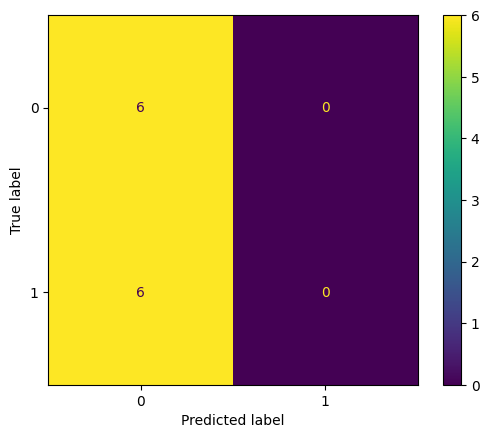

In [81]:
pred = classify_phasors(df)

[INFO] 2 unique segments found


C:\Users\dan-w\AppData\Local\Temp\ipykernel_31664\2136470479.py:4: RuntimeWarning: invalid value encountered in divide
  G=fft[:,:,1].real/fft[:,:,0].real
C:\Users\dan-w\AppData\Local\Temp\ipykernel_31664\2136470479.py:7: RuntimeWarning: invalid value encountered in divide
  S=fft[:,:,1].imag/fft[:,:,0].real


[INFO] 8 unique segments found
[INFO] 8 unique segments found
[INFO] 9 unique segments found
[INFO] 8 unique segments found
35.714285714285715


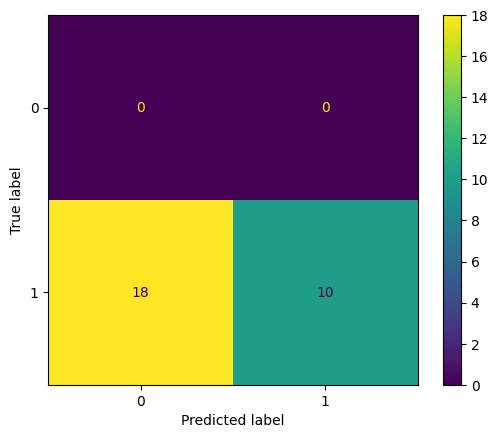

In [78]:
df2 = user_grouping()
score = test_accuracy(df, df2)

In [80]:
print(df2['Labels'])

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
Name: Labels, dtype: int64


In [ ]:
def main():
    df = kmeans_points()
    # df g and s come in a list, if can split those into columns and create dummies, can random forest classify

    # df = df.apply(lambda x: x['G'].flatten(), axis=1)
    # print(df['S'])
    # for col in df.columns:
    #     print(col)
    # G_columns = len(df['G'][0])
    # S_columns = len(df['S'][0])
    # print(G_columns)
    # print(S_columns)
    # G_col = []
    # S_col = []

    # for i in range(G_columns):
    #     G_col.append(f"G{i}")

    # for i in range(S_columns):
    #     S_col.append(f"S{i}")

    # df[G_col] = pd.DataFrame(df.G.tolist(), index= df.index)
    # df[S_col] = pd.DataFrame(df.S.tolist(), index= df.index)

    # print(df)